## Stock Return Prediction

One of the most popular problems in Finance is to predict stock returns using public data available. In this case study, we will extract data from Yahoo Finance and apply a range of techniques.

#### Python imports

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


C:\Users\sahil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Data extraction

Next, we extract the data required for our case study from Yahoo Finance and the FRED database. We do this using pandas datareader. The following data series are extracted

1. Stock tickers:

    a. Microsoft (MSFT)

    b. IBM (IBM)

    c. Alphabet (GOOGL)


2. Currency:

    a. USD/JPY
    
    b. GBP/USD


3. Indices:
    
    a. S&P 500
    
    b. Dow Jones
    
    c. VIX

In [2]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

In [4]:
return_period = 5

We now define our Y series and our X series

Y: MSFT **Future** Returns

X:

    a. GOOGL 5 Business Day Returns

    b. IBM 5 Business DayReturns
    
    c. USD/JPY 5 Business DayReturns
    
    d. GBP/USD 5 Business DayReturns
    
    e. S&P 500 5 Business DayReturns
    
    f. Dow Jones 5 Business DayReturns
    
    g. MSFT 5 Business Day Returns
    
    h. MSFT 15 Business Day Returns
    
    i. MSFT 30 Business Day Returns
    
    j. MSFT 60 Business Day Returns

We remove the MSFT past returns when we use the Time series models.

In [5]:
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

Lets have a look at the dataset we have

In [7]:
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,443.000,443.000,4.430e+02,4.430e+02,4.430e+02,443.000,443.000,443.000,443.000,443.000,443.000,443.000
mean,0.004,0.002,1.666e-04,3.081e-04,-4.670e-04,0.001,0.001,0.003,0.003,0.011,0.022,0.043
std,0.029,0.033,2.580e-02,1.340e-02,1.251e-02,0.018,0.017,0.151,0.029,0.047,0.066,0.090
min,-0.122,-0.138,-1.011e-01,-5.245e-02,-1.112e-01,-0.075,-0.071,-0.496,-0.122,-0.137,-0.212,-0.223
25%,-0.014,-0.016,-1.336e-02,-7.328e-03,-8.025e-03,-0.007,-0.008,-0.094,-0.014,-0.017,-0.015,-0.019
50%,0.004,0.004,1.413e-03,0.000e+00,-6.451e-04,0.004,0.003,-0.006,0.003,0.015,0.026,0.052
75%,0.021,0.021,1.579e-02,7.730e-03,7.501e-03,0.012,0.012,0.080,0.020,0.040,0.060,0.101
max,0.113,0.230,9.713e-02,5.811e-02,5.023e-02,0.055,0.056,0.781,0.113,0.146,0.214,0.266


In [9]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2010-03-31,0.021,1.741e-02,-0.002,1.630e-02,0.018,0.001,0.002,0.002,-0.012,0.011,0.024,-0.050
2010-04-08,0.031,6.522e-04,-0.005,-7.166e-03,-0.001,0.007,0.000,-0.058,0.021,0.010,0.044,-0.007
2010-04-16,0.009,-2.879e-02,0.014,-1.349e-02,0.002,-0.002,0.002,0.129,0.011,0.022,0.069,0.007
2010-04-23,-0.014,-9.424e-03,-0.005,2.309e-02,-0.002,0.021,0.017,-0.100,0.009,0.060,0.059,0.047
2010-04-30,-0.079,-3.604e-02,-0.008,6.369e-04,-0.004,-0.025,-0.018,0.283,-0.014,0.007,0.031,0.069


Next, lets look at the distribution of the data over the entire period

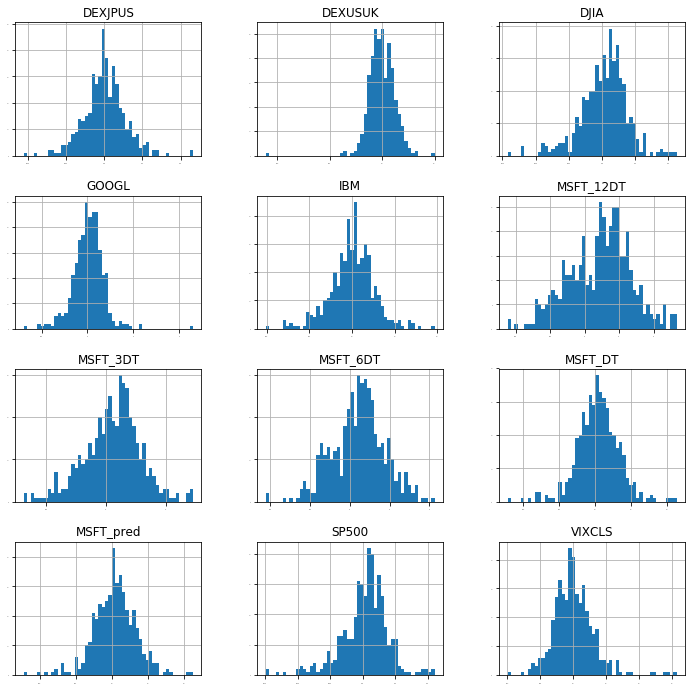

In [12]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

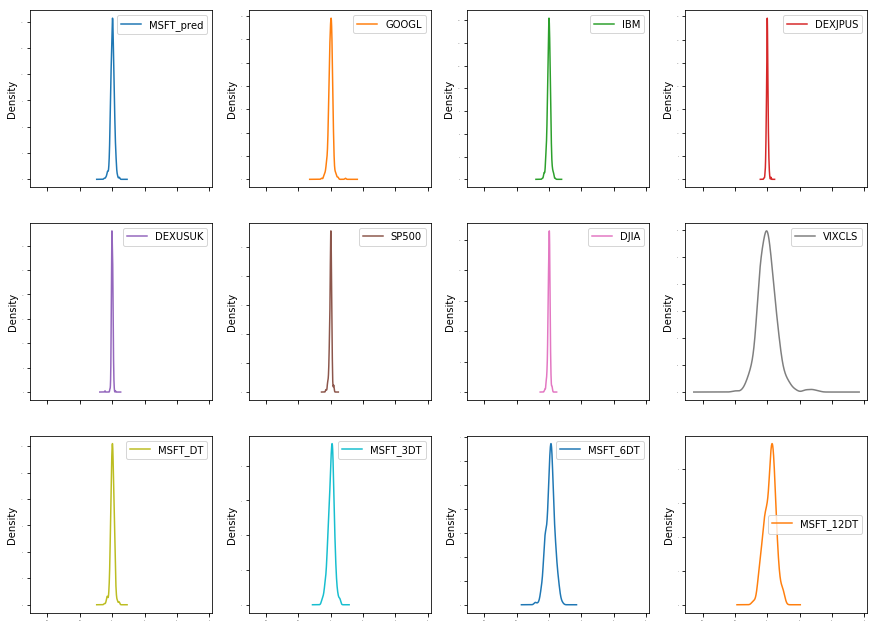

In [10]:
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

In order to get a sense of the interdependence of the data we look at the scatter plot and the correlation matrix

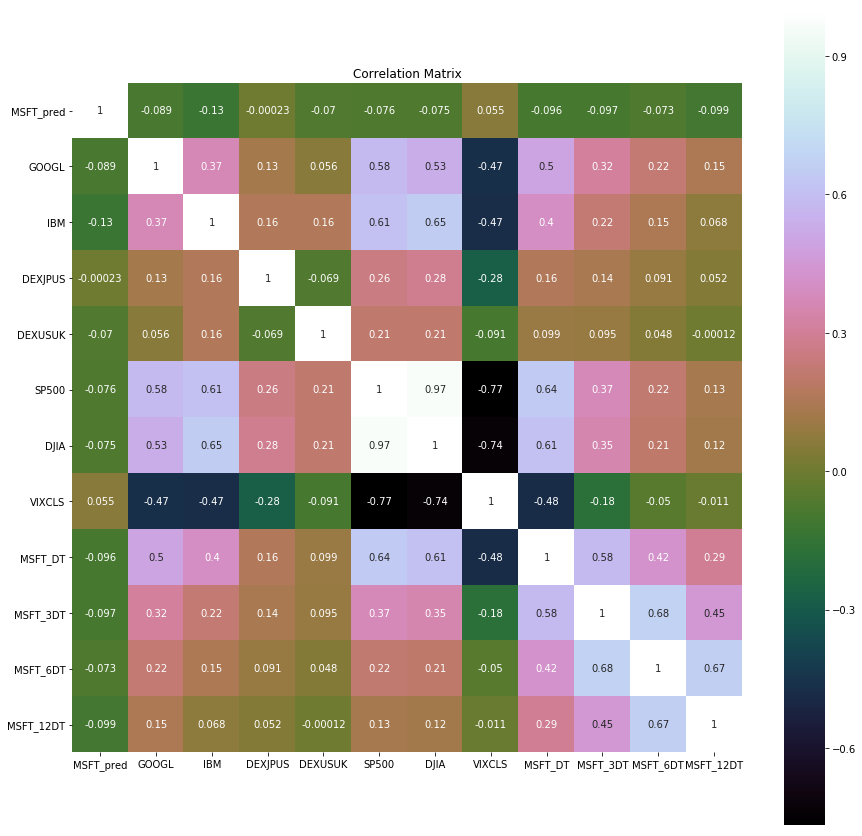

In [13]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

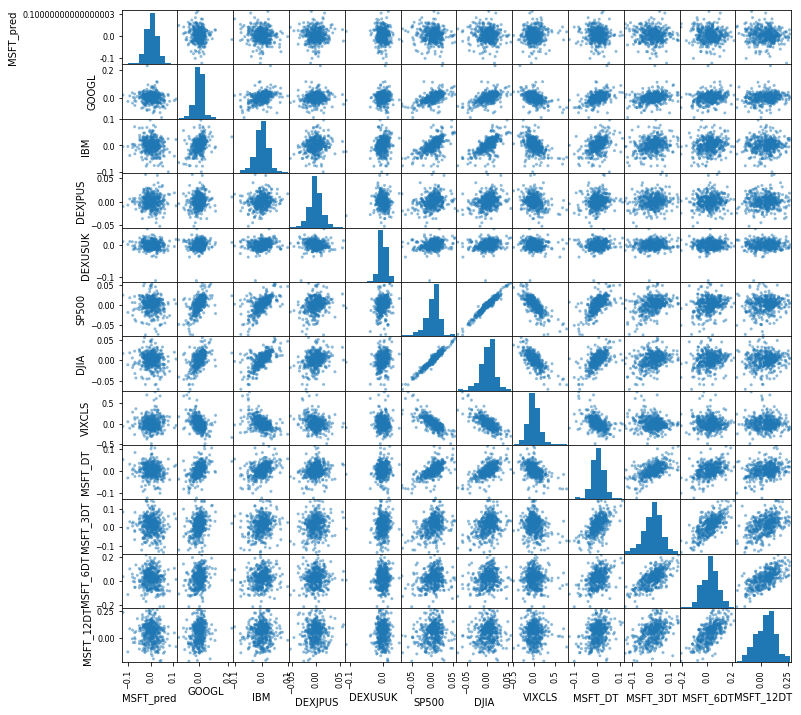

In [14]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

We don't see strong correlation between any of the 2 series. Nor do we see any sepcial structure between our target prediction variable and our features. Given this, we expect that a simple model would be able to as well as a complex model.

Next, we look at the seasonal decomposition of our time series

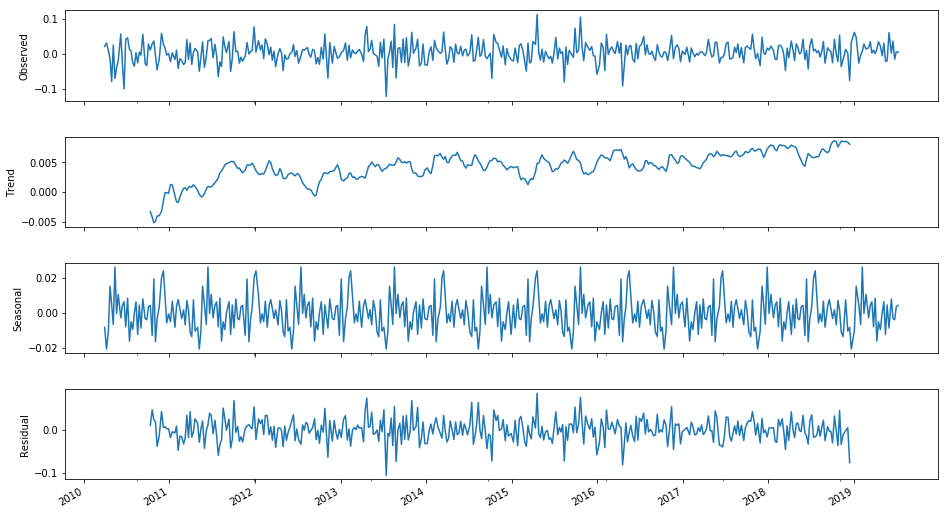

In [15]:
res = sm.tsa.seasonal_decompose(Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for MSFT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

Next, we look at the autocorrelation of our series. This should pick up on short term dependencies

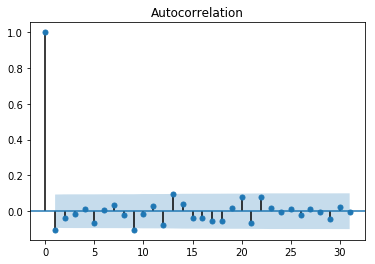

In [17]:
plot_acf(Y, lags=31)
pyplot.show()

We see no evidence of any autocorrelation. This implies that our time seires models will be of limited use. 

#### Univariate Feature selection

We start by looking at each feature individually. This gives us a sense of feature importance. For this case we will use univariate regression fit as the criteria

In [22]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
IBM,7.661
MSFT_12DT,4.399
MSFT_3DT,4.230
MSFT_DT,4.136
GOOGL,3.535
SP500,2.535
DJIA,2.464
MSFT_6DT,2.388
DEXUSUK,2.148


We see that IBM seems to be the most important feature and vix being the least important.

#### Train and Test data split

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

In [23]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

#### Scikit Models

We begin by using scikit models. The have the advantage of being able to run on multiple folds of the training data. This allows us to get better sense of the results we can expect on the final test set. There are 3 types of scikit models we will be using

In [26]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

##### Regression and Tree Regression algorithms

In [27]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [30]:
models.append(('MLP', MLPRegressor()))

##### Ensable Models

In [31]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K fold analysis. Next we run the model on the entire training and testing dataset.

In [34]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000935 (0.000443) 0.000862 0.000671
LASSO: 0.000901 (0.000431) 0.000898 0.000646
EN: 0.000901 (0.000431) 0.000898 0.000646
KNN: 0.001050 (0.000412) 0.000758 0.000908
CART: 0.002201 (0.000617) 0.000000 0.001640
SVR: 0.000963 (0.000472) 0.000923 0.000731
MLP: 0.001778 (0.000548) 0.001395 0.000678
ABR: 0.001067 (0.000423) 0.000648 0.000761
GBR: 0.001119 (0.000523) 0.000232 0.000781
RFR: 0.001157 (0.000511) 0.000212 0.000775
ETR: 0.001188 (0.000490) 0.000000 0.000786


#### K Fold results

We being by looking at the K Fold results

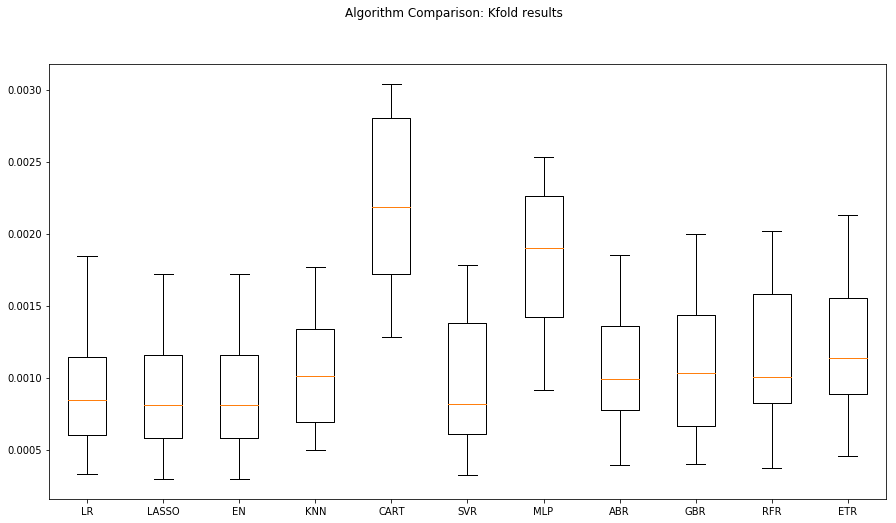

In [37]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

We see the the linear regression,, the Lasso regression and the elastic net seem to do a good job.

#### Training and Test error

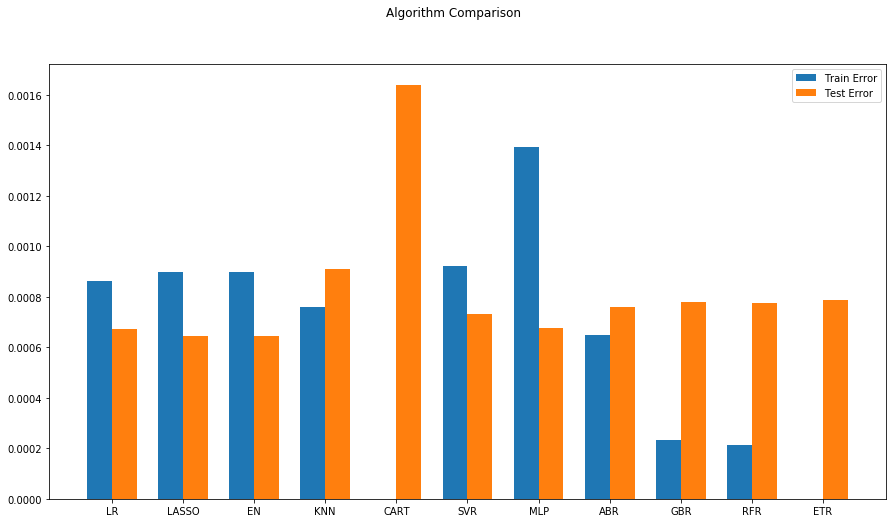

In [38]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Looking at the training and test error, we see some of the algorithms such as the decision tree regressor(CART) overfit on the training data and produced a terrible result on the test set. We also see that the Multi layer preceptron (MLP) algorithm was perhaps not not given enough number of nodes or perhaps wasn't trained as long.

Our original intuition from the Kfold results and the scatter plot seem to point to the simpler models in this case.

#### Time series models

We now look at some of the Time series models that can be used. As mentioned earlier, we remove MSFT's previous returns for these models. Due to the nature of Time series models, we are not able to run a K fold analysis. We can still compare our results to the our models based on the full training and testing results.

##### ARIMAX Model

In [42]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [43]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

C:\Users\sahil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [46]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)

C:\Users\sahil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


##### LSTM Model

In [47]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [53]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

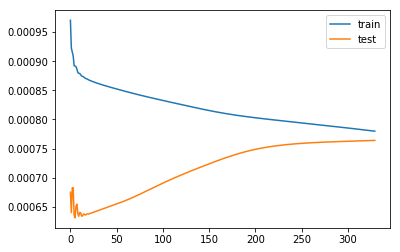

In [54]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [57]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

#### Append to previous results

In [58]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

#### Final comparison

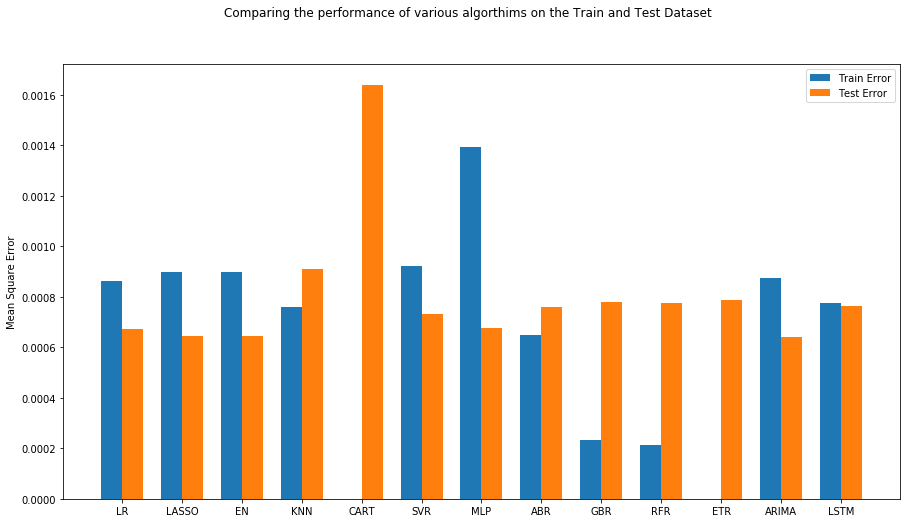

In [60]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

### Summary

In this case study we looked at various models that can we used to predict stock returns. These models ranged from the simple to the very complex. 

We find that the simple models - Linear Regression (LR), Lasso Regression (LASSO) and Elastic Net (EN) perform the best of our test sample.

We observe cases where models are potentially overfitting and cases where they might be underfitting the data.

We should also note that we are limited by the dataset we have. Using a better set of indicators, such as P/E ratio or market cap information might lead to better results across all models.